## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
import psycopg2
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
conn = psycopg2.connect(database='mid_term_project',user='lhl_student',password='lhl_student', host='mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com', port='5432')

print('Connection opened successfully')

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Connection opened successfully


In [2]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df


#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [3]:
column_names = ['arr_delay']
delays = postgresql_to_dataframe(conn, 'SELECT arr_delay FROM flights', column_names)

In [4]:
print(delays.shape)
print(delays.mean())

(15927485, 1)
arr_delay    5.475932
dtype: float64


In [5]:
delays = delays.fillna(0)

In [6]:
delays_nooutliers = delays[(delays['arr_delay'] < 250)&(delays['arr_delay'] > -60)]

In [7]:
print(delays_nooutliers['arr_delay'].describe())
shapiro_test = stats.shapiro(delays_nooutliers['arr_delay'])
shapiro_test

count    1.583836e+07
mean     3.064837e+00
std      3.413541e+01
min     -5.900000e+01
25%     -1.500000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.490000e+02
Name: arr_delay, dtype: float64


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.7248700857162476, 0.0)

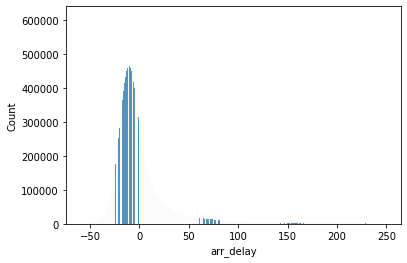

In [8]:
sns.histplot(data=delays_nooutliers, x='arr_delay')
plt.show()

In [9]:
stats.ttest_1samp(delays_nooutliers['arr_delay'], 0)

Ttest_1sampResult(statistic=357.31997227134013, pvalue=0.0)

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [10]:
column_names = ['date','delay']
delays = postgresql_to_dataframe(conn, 'SELECT fl_date, arr_delay FROM flights', column_names)
delays = delays.fillna(0)
delays['date'] = pd.to_datetime(delays['date'])
delays = delays.set_index('date')

In [11]:
median_delays_by_month = delays.groupby([(delays.index.year),(delays.index.month)]).median()
mean_delays_by_month = delays.groupby([(delays.index.year),(delays.index.month)]).mean()

In [12]:
mean_delays_by_month

delay
date date           
2018 1      3.174404
     2      4.051883
     3      2.053084
     4      3.548852
     5      5.882243
     6      8.619621
     7      8.786836
     8      9.840758
     9      2.931579
     10     3.033436
     11     5.524317
     12     3.660244
2019 1      4.559447
     2      8.985047
     3      3.412902
     4      4.588739
     5      6.865583
     6     11.692696
     7      8.755337
     8      7.584691
     9      0.467555
     10     2.621728
     11     0.453388
     12     6.360014

In [13]:
median_delays_by_month

delay
date date       
2018 1      -8.0
     2      -6.0
     3      -6.0
     4      -6.0
     5      -5.0
     6      -4.0
     7      -4.0
     8      -4.0
     9      -7.0
     10     -6.0
     11     -5.0
     12     -6.0
2019 1      -6.0
     2      -4.0
     3      -6.0
     4      -7.0
     5      -5.0
     6      -3.0
     7      -5.0
     8      -6.0
     9      -8.0
     10     -7.0
     11     -8.0
     12     -5.0

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [14]:
column_names = ['dep_time','arr_time','taxi_out','taxi_in']
taxi = postgresql_to_dataframe(conn, 'SELECT dep_time, arr_time, taxi_out, taxi_in FROM flights', column_names)
taxi_no_na = taxi.fillna(0)

In [16]:
dep_taxi = taxi_no_na[['dep_time','taxi_out']].copy(deep = True)
dep_taxi['dep_time'] = dep_taxi['dep_time'] / 100
dep_taxi['dep_time'] = dep_taxi['dep_time'].astype(int)
dep_taxi = dep_taxi.set_index('dep_time')

In [17]:
arr_taxi = taxi_no_na[['arr_time','taxi_in']].copy(deep = True)
arr_taxi['arr_time'] = arr_taxi['arr_time'] / 100
arr_taxi['arr_time'] = arr_taxi['arr_time'].astype(int)
arr_taxi = arr_taxi.set_index('arr_time')

In [18]:
dep_taxi_hourly_mean = dep_taxi.groupby(dep_taxi.index).mean()

In [19]:
arr_taxi_hourly_mean = arr_taxi.groupby(arr_taxi.index).mean()

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [20]:
column_names = ['arr_delay','dep_delay']
arr_vs_dep_delay = postgresql_to_dataframe(conn, 'SELECT arr_delay, dep_delay FROM flights', column_names)

In [21]:
percentage_delays_bef_dep = arr_vs_dep_delay[arr_vs_dep_delay['arr_delay'] == arr_vs_dep_delay['dep_delay']].count() / arr_vs_dep_delay.count()

In [22]:
percentage_delays_bef_dep['arr_delay'] * 100

2.832494468242013

In [23]:
delays_decreased = arr_vs_dep_delay[arr_vs_dep_delay['arr_delay'] < arr_vs_dep_delay['dep_delay']].count() / arr_vs_dep_delay.count()

In [24]:
delays_decreased['arr_delay'] * 100

71.01194877655821

#### **Task 6**: How many states cover 50% of US air traffic? 

In [25]:
column_names = ['origin_city_name','dest_city_name','flights']
traffic = postgresql_to_dataframe(conn, 'SELECT origin_city_name, dest_city_name, flights FROM flights', column_names)


In [ ]:
traffic.head()

,origin_city_name,dest_city_name,flights
0,"Dallas/Fort Worth, TX","San Antonio, TX",1.0
1,"San Antonio, TX","Dallas/Fort Worth, TX",1.0
2,"Miami, FL","Baltimore, MD",1.0
3,"Orlando, FL","Miami, FL",1.0
4,"Miami, FL","Orlando, FL",1.0


In [29]:
traffic['origin_state'] = traffic['origin_city_name'].str[-2:]
traffic['dest_state'] = traffic['dest_city_name'].str[-2:]
traffic.head()

,origin_city_name,dest_city_name,flights,origin_state,dest_state
0,"Dallas/Fort Worth, TX","San Antonio, TX",1.0,TX,TX
1,"San Antonio, TX","Dallas/Fort Worth, TX",1.0,TX,TX
2,"Miami, FL","Baltimore, MD",1.0,FL,MD
3,"Orlando, FL","Miami, FL",1.0,FL,FL
4,"Miami, FL","Orlando, FL",1.0,FL,FL


In [81]:
traffic_origin = traffic.groupby(['origin_state']).sum('flights').sort_values('flights', ascending=False).reset_index()
traffic_origin.head()

,origin_state,flights
0,CA,1738254.0
1,TX,1572078.0
2,FL,1151221.0
3,IL,1008184.0
4,GA,841057.0


In [82]:
traffic_dest = traffic.groupby('dest_state').sum('flights').sort_values('flights', ascending=False).reset_index()
traffic_dest.head()

,dest_state,flights
0,CA,1738330.0
1,TX,1572051.0
2,FL,1151320.0
3,IL,1008051.0
4,GA,841095.0


In [87]:
traffic_origin['overall_prc'] = (traffic_origin['flights']/traffic_origin['flights'].sum())*100
traffic_origin['cumsum_states'] = traffic_origin['overall_prc'].cumsum()
traffic_origin[traffic_origin['cumsum_states']<=50]

,origin_state,flights,overall_prc,cumsum_states
0,CA,1738254.0,10.913550,10.913550
1,TX,1572078.0,9.870221,20.783771
2,FL,1151221.0,7.227889,28.011660
3,IL,1008184.0,6.329838,34.341498
4,GA,841057.0,5.280539,39.622037
5,NY,827854.0,5.197644,44.819681
6,NC,736077.0,4.621426,49.441108


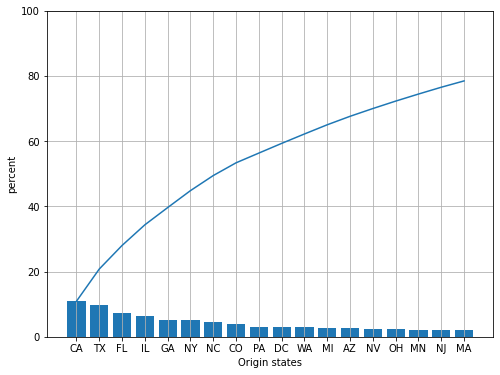

In [114]:
all = traffic_origin[traffic_origin['cumsum_states']<=80]
x = all['origin_state']
y = all['overall_prc']
cumsum = all['cumsum_states']
fig,ax = plt.subplots(figsize = (8,6))
ax.bar(x, y)
ax.plot(x, cumsum)
ax.set_ylim(0,100)
ax.set_xlabel('Origin states')
ax.set_ylabel('percent')
plt.grid()
plt.show()

In [88]:
traffic_dest['overall_prc'] = (traffic_dest['flights']/traffic_dest['flights'].sum())*100
traffic_dest['cumsum_states'] = traffic_dest['overall_prc'].cumsum()
traffic_dest[traffic_dest['cumsum_states']<=50]

,dest_state,flights,overall_prc,cumsum_states
0,CA,1738330.0,10.914027,10.914027
1,TX,1572051.0,9.870052,20.784079
2,FL,1151320.0,7.228511,28.012590
3,IL,1008051.0,6.329003,34.341593
4,GA,841095.0,5.280777,39.622370
5,NY,827847.0,5.197600,44.819970
6,NC,736070.0,4.621382,49.441352


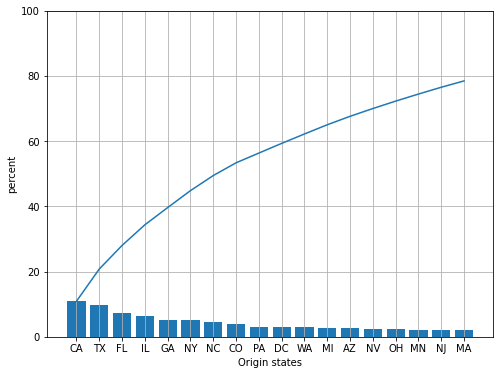

In [115]:
all = traffic_dest[traffic_dest['cumsum_states']<=80]
x = all['dest_state']
y = all['overall_prc']
cumsum = all['cumsum_states']
fig,ax = plt.subplots(figsize = (8,6))
ax.bar(x, y)
ax.plot(x, cumsum)
ax.set_ylim(0,100)
ax.set_xlabel('Origin states')
ax.set_ylabel('percent')
plt.grid()
plt.show()

Origin and Destination states percent are almost the same

Another example of percentage of each direction from one state to another. As we can see in-state flights are the most frequent.

In [90]:
traffic_all = traffic.groupby(['origin_state','dest_state']).sum('flights').sort_values('flights', ascending=False).reset_index()
traffic_all['overall_prc'] = (traffic_all['flights']/traffic_all['flights'].sum())*100
traffic_all['cumsum_states'] = traffic_all['overall_prc'].cumsum()
traffic_all[traffic_all['cumsum_states']<=50]

,origin_state,dest_state,flights,overall_prc,cumsum_states
0,CA,CA,555071.0,3.484988,3.484988
1,TX,TX,404107.0,2.537168,6.022156
2,HI,HI,150811.0,0.946860,6.969016
3,TX,CA,142863.0,0.896959,7.865975
4,CA,TX,142795.0,0.896532,8.762507
...,...,...,...,...,...
119,NC,DC,31312.0,0.196591,49.212396
120,IL,NC,31150.0,0.195574,49.407970
121,MI,FL,31124.0,0.195411,49.603381
122,FL,MI,31112.0,0.195335,49.798716


#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [16]:
column_names = ['op_carrier_fl_num','dep_time','arr_time', 'air_time','distance','dep_delay', 'arr_delay']
dep_delays = postgresql_to_dataframe(conn, 'SELECT op_carrier_fl_num, dep_time, arr_time, air_time, distance, dep_delay, arr_delay FROM flights where cancelled = 0', column_names)
dep_delays.describe()

,op_carrier_fl_num,dep_time,arr_time,air_time,distance,dep_delay,arr_delay
count,1.565828e+07,1.565827e+07,1.565240e+07,1.561226e+07,1.565828e+07,1.565353e+07,1.561574e+07
mean,2.726165e+03,1.334210e+03,1.464147e+03,1.079393e+02,7.706748e+02,1.051805e+01,5.475932e+00
std,1.861704e+03,5.035536e+02,5.369109e+02,6.967538e+01,5.873683e+02,4.773285e+01,4.987401e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.384000e+03,1.600000e+01,-1.280000e+03,-1.290000e+03
25%,1.120000e+03,9.170000e+02,1.048000e+03,5.800000e+01,3.420000e+02,-6.000000e+00,-1.500000e+01
50%,2.305000e+03,1.327000e+03,1.503000e+03,8.900000e+01,6.050000e+02,-2.000000e+00,-6.000000e+00
75%,4.308000e+03,1.744000e+03,1.914000e+03,1.370000e+02,1.005000e+03,7.000000e+00,8.000000e+00
max,9.401000e+03,2.400000e+03,2.400000e+03,1.557000e+03,5.095000e+03,2.976000e+03,2.973000e+03


In [17]:
dep_delays.isnull().sum()

op_carrier_fl_num        0
dep_time                 8
arr_time              5880
air_time             46013
distance                 0
dep_delay             4744
arr_delay            42536
dtype: int64

In [35]:
dep_delays = dep_delays.dropna()
dep_delays.isnull().sum()

op_carrier_fl_num    0
dep_time             0
arr_time             0
air_time             0
distance             0
dep_delay            0
arr_delay            0
dtype: int64

In [36]:
dep_delays.shape

(15605077, 7)

In [41]:
delays_no_tail = dep_delays[(dep_delays['arr_delay'] < 250)&(dep_delays['arr_delay'] > -60) & (dep_delays['dep_delay'] < 250)&(dep_delays['dep_delay'] > -60)]

In [ ]:
delays_no_tail[['dep_delay','arr_delay']].sort_values(by = 'dep_delay',ascending = False)

In [51]:
delays_no_tail['delay_diff'] = delays_no_tail['dep_delay']-delays_no_tail['arr_delay']
delays_no_tail.head()
#delay_diff - how early or fast plane came to destination airport
# negative = delay
# positive = ahead of time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,op_carrier_fl_num,dep_time,arr_time,air_time,distance,dep_delay,arr_delay,delay_diff
0,53,1615.0,2043.0,402.0,2475.0,0.0,48.0,-48.0
1,54,1744.0,2030.0,322.0,2174.0,-6.0,4.0,-10.0
2,55,1705.0,1941.0,82.0,599.0,1.0,-19.0,20.0
3,56,1151.0,1349.0,95.0,632.0,1.0,-9.0,10.0
4,56,1443.0,1650.0,100.0,632.0,0.0,-2.0,2.0


In [77]:
stats, p_value = stats.shapiro(delays_no_tail['delay_diff'])
print('Test statistic: ', stats)
print('P-value:', p_value)

Test statistic:  0.9312943816184998
P-value: 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


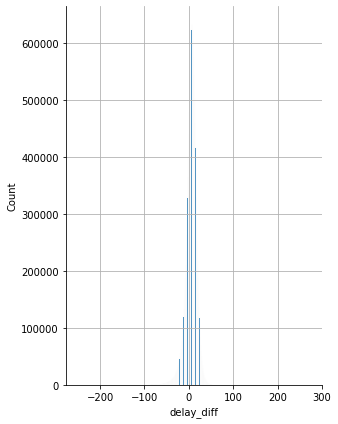

In [59]:
sns.displot(data = delays_no_tail, x = delays_no_tail['delay_diff'], height=6, aspect=0.8)
plt.grid()
plt.show()

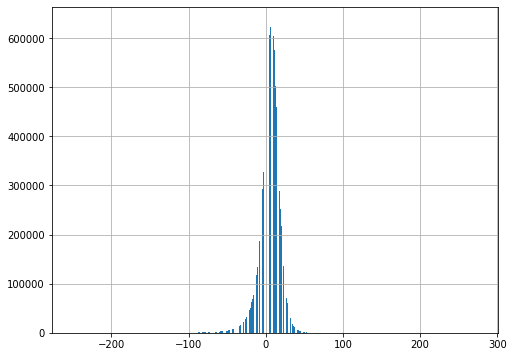

In [78]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(delays_no_tail['delay_diff'],bins=1000)
plt.grid()
plt.show()

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

***Route category lengths tend to define short-haul routes as being shorter than 600–800 nmi (1,100–1,500 km), long-haul as being longer than 2,200–2,600 nmi (4,100–4,800 km), and medium-haul as being in-between.***
https://en.wikipedia.org/wiki/Flight_length 

In [3]:
column_names = ['fl_date','dep_time','arr_time','distance','flights']
flights = postgresql_to_dataframe(conn, 'SELECT fl_date, dep_time, arr_time, distance, flights FROM flights where cancelled = 0 and diverted = 0', column_names)
flights.head()

,fl_date,dep_time,arr_time,distance,flights
0,2019-03-02,1615.0,2043.0,2475.0,1.0
1,2019-03-02,1744.0,2030.0,2174.0,1.0
2,2019-03-02,1705.0,1941.0,599.0,1.0
3,2019-03-02,1151.0,1349.0,632.0,1.0
4,2019-03-02,1443.0,1650.0,632.0,1.0


In [4]:
flights.isnull().sum()

fl_date      0
dep_time     8
arr_time    10
distance     0
flights      0
dtype: int64

In [5]:
flights.shape

(15618340, 5)

In [6]:
flights = flights.dropna()
print(flights.shape)
flights.isnull().sum()

(15618329, 5)


fl_date     0
dep_time    0
arr_time    0
distance    0
flights     0
dtype: int64

In [7]:
flights['flight_length'] = np.select (
    [ 
     (flights['distance'] < 800),
     (flights['distance'].between(800, 2200, inclusive=False)),
     (flights['distance'] >=2200)
    ], 
    [
     'SHORT',
     'MEDIUM',
     'LONG'
    ]
                                    )
flights.head(2)

,fl_date,dep_time,arr_time,distance,flights,flight_length
0,2019-03-02,1615.0,2043.0,2475.0,1.0,LONG
1,2019-03-02,1744.0,2030.0,2174.0,1.0,MEDIUM


In [8]:
flights['dep_hours'] = flights['dep_time'] // 100
flights['arr_hours'] = flights['arr_time'] // 100
flights.head()

,fl_date,dep_time,arr_time,distance,flights,flight_length,dep_hours,arr_hours
0,2019-03-02,1615.0,2043.0,2475.0,1.0,LONG,16.0,20.0
1,2019-03-02,1744.0,2030.0,2174.0,1.0,MEDIUM,17.0,20.0
2,2019-03-02,1705.0,1941.0,599.0,1.0,SHORT,17.0,19.0
3,2019-03-02,1151.0,1349.0,632.0,1.0,SHORT,11.0,13.0
4,2019-03-02,1443.0,1650.0,632.0,1.0,SHORT,14.0,16.0


In [67]:
flight_dep = flights[['flight_length','dep_hours','flights']].groupby(['flight_length','dep_hours']).count().sort_values(by ='flights', ascending = False).reset_index()
flight_dep = flight_dep.rename(columns = {'flights':'flights_dep'})                         
flight_arr =  flights[['flight_length','arr_hours','flights']].groupby(['flight_length','arr_hours']).count().sort_values(by ='flights', ascending = False).reset_index()
flight_arr = flight_arr.rename(columns = {'flights':'flights_arr'})
df_flights = pd.concat([flight_dep,flight_arr])
flight_dep.head()

,flight_length,dep_hours,flights_dep
0,SHORT,17.0,632056
1,SHORT,12.0,612764
2,SHORT,15.0,599831
3,SHORT,10.0,594807
4,SHORT,11.0,590640


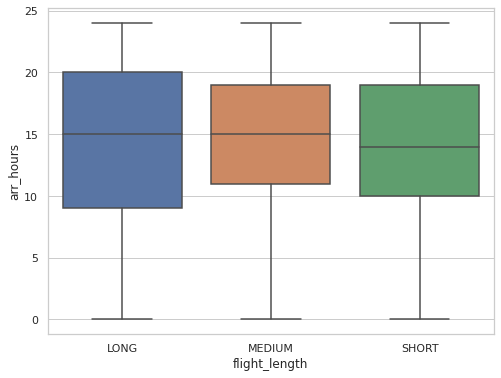

In [80]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data = flights, x = flights['flight_length'], y = flights['arr_hours'])
plt.show()

For this plot RAM is not enough you can try, but I'm not sure

In [ ]:
trace1 = go.Bar(
    x=df_flights['flight_length'], 
    y=df_flights['dep_hours'],
    name = 'Departure hours',
    marker=dict(color='Yellow') 
)

trace2 = go.Bar(
    x=df_flights['flight_length'],
    y=df_flights['arr_hours'],
    name='Arrival Hours',
    marker=dict(color='Green') 
)

data = [trace1, trace2]

layout = go.Layout(
    title='Hours when haul flights take off'
)

fig = go.Figure(data=data, layout=layout)
fig.show()

This plot is working, but looks weird, mb I'll change it


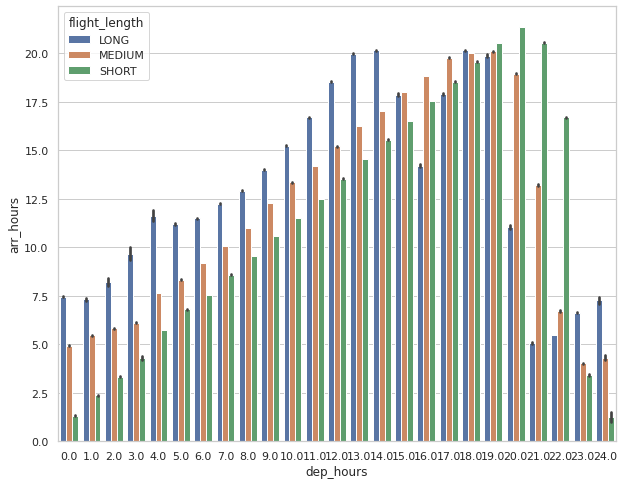

In [15]:
#hr = dict(dep_hours = flights['dep_hours'], arr_hours = flights['arr_hours'])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data = flights, x = flights['dep_hours'], y = flights['arr_hours'], hue = flights['flight_length'])
plt.show()

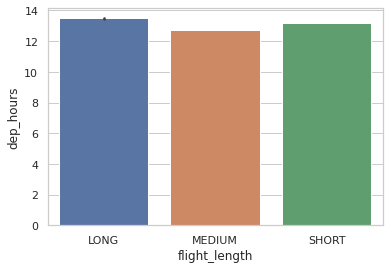

In [13]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data = flights, x = flights['flight_length'], y = flights['dep_hours'])
plt.show()

In [ ]:
hr = dict(dep_hours = flight_dep['dep_hours'], arr_hours = flight_arr['arr_hours'])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data = flights, x = flights['flight_length'], y = flights['arr_hours'])
plt.show()

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?